# Discovery of Non-Linear Double Pendulum Dynamics using SODAs

This notebook documents the process of discovering the equations of motiona non-linear pendulum (away from small angle approximations) from pixel data of a video footage of swining pendulum with different initial conditions. The animations used for this analysis are created from . 

## Details of the Animation
- **Numerical Method**: Runge-Kutta adaptive method
- **Initial Time Step**: 0.0025
- **Damping**: 0.5
- **Frame Rate**: 60 Hz (recorded using QuickTime Player which supports 60 fps recording)

## Workflow
1. **Loading Video Footage**: The video footage of the pendulum is loaded using `cv2`, an open-source computer vision package in Python.
2. **Tracking the Pendulum Bob**: The x and y coordinates of the pendulum bob are tracked. The pivot point is centered at the origin.
3. **Normalization**: The length of the pendulum is normalized to be 1.
4. **Data Processing**: SODAs is applied to the (x,y) coordinates to find the algebraic constraints in the system using.
5. **Equation Discovery**: After the coordinat system is discovered, we transition into polar coordinates where the appropriate library functions are craeted to discover the polar equation of the pendulum.

In [1]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))


import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import sympy
from dae_finder import construct_reduced_fit_list

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp




from matplotlib import pyplot as plt
from dae_finder import smooth_data
from dae_finder import add_noise_to_df
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from dae_finder import get_simplified_equation_list
from dae_finder import get_refined_lib, remove_paranth_from_feat
from dae_finder import AlgModelFinder
from dae_finder import sequentialThLin, AlgModelFinder
from dae_finder import PolyFeatureMatrix
from copy import deepcopy



/Users/manu_jay/git_repos/DAE-FINDER_dev/daeFinder


# Tracking from Pendulum video footage

- Run this section only once to get the (x,y) coordinates. 
- If this section is ran once, move to Loading of data directly.

### Finding the reference point (hook of pendulum)

In [ ]:
import cv2
import numpy as np

def pick_color(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Left mouse click
        pixel = frame[y, x]
        hsv_pixel = cv2.cvtColor(np.uint8([[pixel]]), cv2.COLOR_BGR2HSV)[0][0]
        print(f"HSV Color at ({x}, {y}): {hsv_pixel}")
ind = 1
video_path = "data/double_pendulum_{}.mov".format(ind)
cap = cv2.VideoCapture(video_path)

cv2.namedWindow("Frame")
cv2.setMouseCallback("Frame", pick_color)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow("Frame", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


### Tracking the pendulum

In [ ]:
import cv2
import numpy as np
import pandas as pd

# Define HSV color range for the pendulum bob (Replace with detected values)
lower_color = np.array([120, 255, 243])  # Adjust as needed
upper_color = np.array([120, 255, 243])  # Adjust as needed

for ind in [3]:
    video_path = "data/double_pendulum_{}_reduced.mov".format(ind)

    cap = cv2.VideoCapture(video_path)

    # Get FPS (frames per second) from video
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_time = 1 / fps  # Time interval between frames

    # List to store detected coordinates with time for both bobs
    positions = []
    frame_count = 0  # To track frame number

    # Initialize previous bob positions for tracking identity
    prev_bob1 = None  # (x1, y1)
    prev_bob2 = None  # (x2, y2)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1  # Track frame number
        time = frame_count * frame_time  # Compute time in seconds

        # Convert frame to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Create a mask for the pendulum bob's color
        mask = cv2.inRange(hsv, lower_color, upper_color)

        # Perform morphological operations to clean the mask
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Find contours from the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) >= 2:
            # Sort contours by area (assuming the two largest are the bobs)
            contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

            bobs = []
            for contour in contours:
                # Get bounding box
                x, y, w, h = cv2.boundingRect(contour)

                # Calculate center of the bounding box
                center_x = x + w // 2
                center_y = y + h // 2
                bobs.append((center_x, center_y))

            # Use tracking to maintain identity
            if prev_bob1 is None or prev_bob2 is None:
                # First frame: assign bobs based on Y-coordinate
                bobs = sorted(bobs, key=lambda c: c[1])
                bob1, bob2 = bobs[0], bobs[1]
            else:
                # Compute distances from previous positions
                d1 = np.linalg.norm(np.array(bobs[0]) - np.array(prev_bob1))
                d2 = np.linalg.norm(np.array(bobs[1]) - np.array(prev_bob1))

                # Assign IDs based on closest match
                if d1 < d2:
                    bob1, bob2 = bobs[0], bobs[1]
                else:
                    bob1, bob2 = bobs[1], bobs[0]

            # Update previous positions
            prev_bob1, prev_bob2 = bob1, bob2

            # Store time and coordinates
            positions.append([time, bob1[0], bob1[1], bob2[0], bob2[1]])

            # Draw tracking markers
            cv2.circle(frame, (bob1[0], bob1[1]), 5, (0, 255, 0), -1)  # First bob (green)
            cv2.circle(frame, (bob2[0], bob2[1]), 5, (0, 0, 255), -1)  # Second bob (red)

            # Display coordinates
            cv2.putText(frame, f"({bob1[0]}, {bob1[1]})", (bob1[0] + 10, bob1[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            cv2.putText(frame, f"({bob2[0]}, {bob2[1]})", (bob2[0] + 10, bob2[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Show the tracking result
        cv2.imshow("Double Pendulum Tracking", frame)

        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Convert positions to a DataFrame and save as CSV
    df = pd.DataFrame(positions, columns=["t", "X1", "Y1", "X2", "Y2"])
    df.to_csv("data/double_pendulum_{}.csv".format(ind), index=False)

    print("Double pendulum position data saved to data/double_pendulum_{}.csv".format(ind))


## Loading data

In [61]:

# Loading pendulum data
df_list = []
for ind in [3]:
    file_path = f"data/double_pendulum_{ind}.csv"
    df = pd.read_csv(file_path)
    df_list.append(df)

# trimming_slices=  [(10,700), (10,700), (10,700), (10,700), (10,700)]
# trimming_slices=  [(0,100), (0,100), (0,100), (0,100), (0,100)]
trimming_slices = [(2,-2), (2,-2)]


df_trimmed = []
for df_, slice in zip(df_list, trimming_slices):
    df_trimmed.append(df_[slice[0]:slice[1]].reset_index(drop=True))

#centering the hook of pendulum to origin
center = (963.5, 750)
color = [120, 255, 243]
for df_ in df_trimmed:
    df_["x_1"] = df_["X1"] - center[0]
    df_["y_1"] = -(df_["Y1"] - center[1])
    df_["x_2"] = df_["X2"] - center[0]
    df_["y_2"] = -(df_["Y2"] - center[1])


# for i, df in enumerate(df_trimmed):
#     df.to_csv(f"data/double_pendulum_trimmed_{i+1}.csv", index=False)

In [62]:
len(df_trimmed)

1

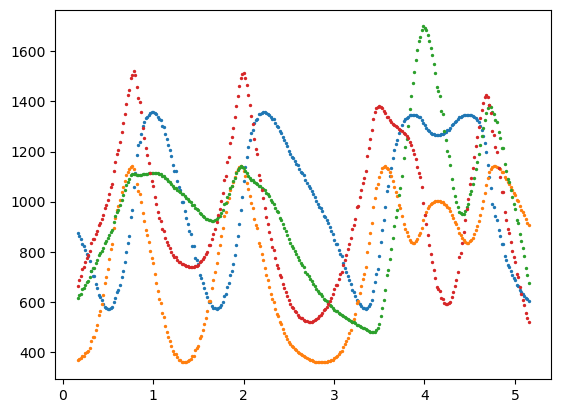

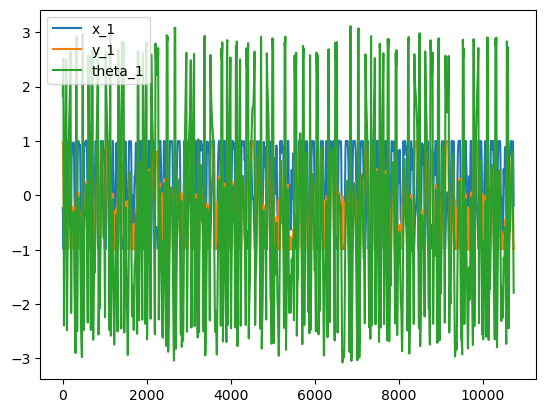

In [63]:
L=1  
smoothening_window_size = 15
pen_orig_len = abs(df_trimmed[0]["y_1"]).max()
#Scaling the pendulum length to L
for df_ in df_trimmed:
    df_["x_1"] = (df_["x_1"]/pen_orig_len) * L
    df_["y_1"] = (df_["y_1"]/pen_orig_len) * L
    df_["x_2"] = (df_["x_2"]/pen_orig_len) * L
    df_["y_2"] = (df_["y_2"]/pen_orig_len) * L

    # df_["x"] = df_["x"].rolling(window=smoothening_window_size, center=True).mean()
    # df_["y"] = df_["y"].rolling(window=smoothening_window_size, center=True).mean()
    df_["theta_1"] = (np.arctan2(df_["y_1"], df_["x_1"])).rolling(window=smoothening_window_size, center=True).mean()
    df_["theta_2"] = (np.arctan2(df_["y_2"]-df_["y_1"], df_["x_2"]-df_["x_1"])).rolling(window=smoothening_window_size, center=True).mean()
    
    df_.dropna(ignore_index=True, inplace=True)
    # df_["theta"] = np.arctan2(df_["y"], df_["x"])
    # df_["theta"] = (np.arctan2(df_["y"], df_["x"])).rolling(window=smoothening_window_size, center=True).mean()
    # df_.dropna(ignore_index=True, inplace=True)

df_appended = pd.concat(df_trimmed, ignore_index=True)

for df_ in df_trimmed:

    # df_[["x_1", "y_1", "x_2", "y_2"]][:100].plot()
    # for feat in ["x_1", "y_1", "x_2", "y_2"]:
    for feat in ["X1", "Y1", "X2", "Y2"]:
        plt.scatter(df_["t"][:300], df_[feat][:300], s=2)
        # plt.plot(df_["t"][:300], df_[feat][:300], ".-")

    # df_[["x_2", "y_2"]].plot()df_appended = pd.concat(df_trimmed, ignore_index=True)

for df_ in df_trimmed:
    df_[["x_1", "y_1", "theta_1"]].plot()


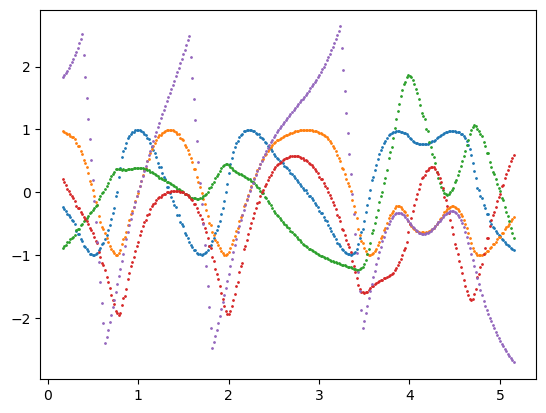

In [65]:
for feat in ["x_1", "y_1", "x_2", "y_2", "theta_1"]:
    plt.scatter(df_["t"][:300], df_[feat][:300], s=1)

<Axes: >

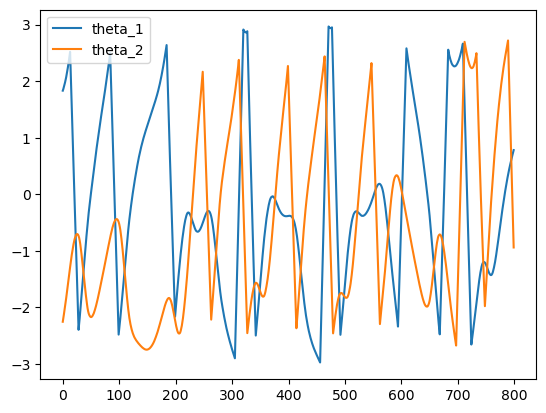

In [66]:
df_appended[["theta_1", "theta_2"]][:800].plot()

## Fomring the candidate library

In [67]:
# Finding the first and second order derivative of the states using Savitzky-Golay Filer

data_matrix_smooth_df_list = [
    smooth_data(data_matrix,
                domain_var="t",
                smooth_method ="SG",
                noise_perc=0.1,
                derr_order=2,
                polyorder=2,
                window_smooth=None) #trimming zero derivatives near end points
    for data_matrix in df_trimmed]



if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0].reset_index(drop=True)
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_new= data_matrix_df_smooth_appended[["theta_1", "theta_2"]]

data_matrix_df_new

,theta_1,theta_2
0,1.13118341,-2.23577010
1,1.12077417,-2.22717134
2,1.11039404,-2.21859202
3,1.10004300,-2.21003216
4,1.08972106,-2.20149175
...,...,...
10728,-0.10751580,-0.54502588
10729,-0.10537012,-0.55066985
10730,-0.10321903,-0.55632573
10731,-0.10106252,-0.56199351


In [68]:
data_matrix_df_smooth_appended

,t,X1,d(X1) /dt,d^2(X1) /dt^2,Y1,d(Y1) /dt,d^2(Y1) /dt^2,X2,d(X2) /dt,d^2(X2) /dt^2,...,d^2(x_2) /dt^2,y_2,d(y_2) /dt,d^2(y_2) /dt^2,theta_1,d(theta_1) /dt,d^2(theta_1) /dt^2,theta_2,d(theta_2) /dt,d^2(theta_2) /dt^2
0,0.16674414,886.42895985,49.39215893,-8.87952030,552.24812838,111.27182572,-17.98513881,855.01539645,45.06890427,-7.11516118,...,-0.01805878,-0.57034970,0.01561987,0.00068989,1.13118341,-0.62513635,0.10465472,-2.23577010,0.51626912,-0.06995192
1,0.18341855,887.25131072,49.24409814,-8.87952030,554.10102057,110.97193408,-17.98513881,855.76590486,44.95026313,-7.11516118,...,-0.01805878,-0.57008915,0.01563137,0.00068989,1.12077417,-0.62339130,0.10465472,-2.22717134,0.51510271,-0.06995192
2,0.20009296,888.07119277,49.09603734,-8.87952030,555.94891223,110.67204244,-17.98513881,856.51443500,44.83162199,-7.11516118,...,-0.01805878,-0.56982841,0.01564288,0.00068989,1.11039404,-0.62164624,0.10465472,-2.21859202,0.51393631,-0.06995192
3,0.21676738,888.88860599,48.94797655,-8.87952030,557.79180338,110.37215079,-17.98513881,857.26098687,44.71298085,-7.11516118,...,-0.01805878,-0.56956748,0.01565438,0.00068989,1.10004300,-0.61990119,0.10465472,-2.21003216,0.51276990,-0.06995192
4,0.23344179,889.70355038,48.79991575,-8.87952030,559.62969401,110.07225915,-17.98513881,858.00556047,44.59433971,-7.11516118,...,-0.01805878,-0.56930635,0.01566588,0.00068989,1.08972106,-0.61815613,0.10465472,-2.20149175,0.51160349,-0.06995192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10728,179.04985281,1164.51264518,61.72201018,8.34316527,803.15975691,-22.46471246,-2.65702266,1172.08367051,95.79314875,15.88764426,...,0.04032397,-0.37571319,-0.09604517,-0.00983188,-0.10751580,0.12851814,0.01949137,-0.54502588,-0.33812401,-0.04281885
10729,179.06652722,1165.54298336,61.86112757,8.34316527,802.78480163,-22.50901675,-2.65702266,1173.68317376,96.05806590,15.88764426,...,0.04032397,-0.37731605,-0.09620911,-0.00983188,-0.10537012,0.12884315,0.01949137,-0.55066985,-0.33883799,-0.04281885
10730,179.08320164,1166.57564123,62.00024495,8.34316527,802.40910760,-22.55332105,-2.65702266,1175.28709434,96.32298305,15.88764426,...,0.04032397,-0.37892165,-0.09637305,-0.00983188,-0.10321903,0.12916815,0.01949137,-0.55632573,-0.33955197,-0.04281885
10731,179.09987605,1167.61061881,62.13936234,8.34316527,802.03267483,-22.59762534,-2.65702266,1176.89543227,96.58790020,15.88764426,...,0.04032397,-0.38052998,-0.09653699,-0.00983188,-0.10106252,0.12949316,0.01949137,-0.56199351,-0.34026595,-0.04281885


In [73]:
# data_matrix_df_new = df_appended[["theta_1", "theta_2"]]
# data_matrix_df_new = data_matrix_df_new.sample(frac=1).reset_index(drop=True)



poly_degree = 2
from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)

In [74]:
candidate_lib_full

candidate_lib_full["sin(theta_1)"] = np.sin(candidate_lib_full["theta_1"])
candidate_lib_full["sin(theta_2)"] = np.sin(candidate_lib_full["theta_2"])
candidate_lib_full["sin(theta_1-theta_2)"] = np.sin(candidate_lib_full["theta_1"]-candidate_lib_full["theta_2"])
candidate_lib_full["cos(theta_1-theta_2)"] = np.cos(candidate_lib_full["theta_1"]-candidate_lib_full["theta_2"])



candidate_lib_full["cos(theta_1)"] = np.cos(candidate_lib_full["theta_1"])
candidate_lib_full["cos(theta_2)"] = np.cos(candidate_lib_full["theta_2"])
candidate_lib_full["cos^2(theta_1-theta_2)"] = np.cos(candidate_lib_full["theta_1"]-candidate_lib_full["theta_2"])**2
# candidate_lib_full["cos^2(theta_2)"] = np.cos(candidate_lib_full["theta_2"])**2




candidate_lib_full

,1,theta_1,theta_2,theta_1^2,theta_1 theta_2,theta_2^2,sin(theta_1),sin(theta_2),sin(theta_1-theta_2),cos(theta_1-theta_2),cos(theta_1),cos(theta_2),cos^2(theta_1-theta_2)
0,1.00000000,1.13118341,-2.23577010,1.27957590,-2.52906603,4.99866792,0.90491647,-0.78693297,-0.22345810,-0.97471354,0.42558922,-0.61703849,0.95006648
1,1.00000000,1.12077417,-2.22717134,1.25613475,-2.49615611,4.96029216,0.90043747,-0.79220958,-0.20489150,-0.97878469,0.43498548,-0.61024912,0.95801947
2,1.00000000,1.11039404,-2.21859202,1.23297492,-2.46351135,4.92215057,0.89587383,-0.79741588,-0.18629857,-0.98249318,0.44430854,-0.60343013,0.96529284
3,1.00000000,1.10004300,-2.21003216,1.21009460,-2.43113041,4.88424216,0.89122686,-0.80255188,-0.16768654,-0.98584036,0.45355780,-0.59658233,0.97188122
4,1.00000000,1.08972106,-2.20149175,1.18749199,-2.39901192,4.84656592,0.88649787,-0.80761761,-0.14906254,-0.98882777,0.46273267,-0.58970654,0.97778036
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10728,1.00000000,-0.10751580,-0.54502588,0.01155965,0.05859889,0.29705321,-0.10730878,-0.51844022,0.42368539,0.90580941,0.99422574,0.85511388,0.82049069
10729,1.00000000,-0.10537012,-0.55066985,0.01110286,0.05802415,0.30323728,-0.10517525,-0.52325817,0.43072840,0.90248161,0.99445370,0.85217421,0.81447305
10730,1.00000000,-0.10321903,-0.55632573,0.01065417,0.05742340,0.30949831,-0.10303584,-0.52806957,0.43776085,0.89909145,0.99467764,0.84920111,0.80836544
10731,1.00000000,-0.10106252,-0.56199351,0.01021363,0.05679648,0.31583670,-0.10089057,-0.53287415,0.44478213,0.89563880,0.99489753,0.84619450,0.80216886


In [72]:
candidate_lib_full["d(theta_1) /dt"] = data_matrix_df_smooth_appended["d(theta_1) /dt"]
candidate_lib_full["d(theta_2) /dt"] = data_matrix_df_smooth_appended["d(theta_2) /dt"]
candidate_lib_full["d^2(theta_1) /dt^2"] = data_matrix_df_smooth_appended["d^2(theta_1) /dt^2"]
candidate_lib_full["d^2(theta_2) /dt^2"] = data_matrix_df_smooth_appended["d^2(theta_2) /dt^2"]


In [75]:
der_list = ["d(theta_1) /dt", "d(theta_2) /dt", "d^2(theta_1) /dt^2", "d^2(theta_2) /dt^2"]
for col_ in candidate_lib_full:
    for der_ in der_list:
        candidate_lib_full[col_+" x "+der_] = candidate_lib_full[col_]*data_matrix_df_smooth_appended[der_]

In [76]:
candidate_lib_full

,1,theta_1,theta_2,theta_1^2,theta_1 theta_2,theta_2^2,sin(theta_1),sin(theta_2),sin(theta_1-theta_2),cos(theta_1-theta_2),...,cos(theta_1) x d^2(theta_1) /dt^2,cos(theta_1) x d^2(theta_2) /dt^2,cos(theta_2) x d(theta_1) /dt,cos(theta_2) x d(theta_2) /dt,cos(theta_2) x d^2(theta_1) /dt^2,cos(theta_2) x d^2(theta_2) /dt^2,cos^2(theta_1-theta_2) x d(theta_1) /dt,cos^2(theta_1-theta_2) x d(theta_2) /dt,cos^2(theta_1-theta_2) x d^2(theta_1) /dt^2,cos^2(theta_1-theta_2) x d^2(theta_2) /dt^2
0,1.00000000,1.13118341,-2.23577010,1.27957590,-2.52906603,4.99866792,0.90491647,-0.78693297,-0.22345810,-0.97471354,...,0.04453992,-0.02977079,0.38573319,-0.31855792,-0.06457599,0.04316303,-0.59392109,0.49048999,0.09942894,-0.06645898
1,1.00000000,1.12077417,-2.22717134,1.25613475,-2.49615611,4.96029216,0.90043747,-0.79220958,-0.20489150,-0.97878469,...,0.04552328,-0.03042807,0.38042399,-0.31434098,-0.06386545,0.04268810,-0.59722100,0.49347843,0.10026126,-0.06701531
2,1.00000000,1.11039404,-2.21859202,1.23297492,-2.46351135,4.92215057,0.89587383,-0.79741588,-0.18629857,-0.98249318,...,0.04649899,-0.03108024,0.37512007,-0.31012465,-0.06315181,0.04221110,-0.60007067,0.49609904,0.10102245,-0.06752409
3,1.00000000,1.10004300,-2.21003216,1.21009460,-2.43113041,4.88424216,0.89122686,-0.80255188,-0.16768654,-0.98584036,...,0.04746696,-0.03172724,0.36982210,-0.30590946,-0.06243516,0.04173208,-0.60247032,0.49835144,0.10171196,-0.06798496
4,1.00000000,1.08972106,-2.20149175,1.18749199,-2.39901192,4.84656592,0.88649787,-0.80761761,-0.14906254,-0.98882777,...,0.04842716,-0.03236904,0.36453071,-0.30169592,-0.06171557,0.04125111,-0.60442092,0.50023585,0.10232933,-0.06839762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10728,1.00000000,-0.10751580,-0.54502588,0.01155965,0.05859889,0.29705321,-0.10730878,-0.51844022,0.42368539,0.90580941,...,0.01937882,-0.04257160,0.10989764,-0.28913453,0.01666734,-0.03661499,0.10544794,-0.27742760,0.01599249,-0.03513247
10729,1.00000000,-0.10537012,-0.55066985,0.01110286,0.05802415,0.30323728,-0.10517525,-0.52325817,0.43072840,0.90248161,...,0.01938326,-0.04258136,0.10979681,-0.28874900,0.01661004,-0.03648912,0.10493927,-0.27597441,0.01587520,-0.03487480
10730,1.00000000,-0.10321903,-0.55632573,0.01065417,0.05742340,0.30949831,-0.10303584,-0.52806957,0.43776085,0.89909145,...,0.01938763,-0.04259095,0.10968974,-0.28834791,0.01655209,-0.03636181,0.10441507,-0.27448208,0.01575615,-0.03461328
10731,1.00000000,-0.10106252,-0.56199351,0.01021363,0.05679648,0.31583670,-0.10089057,-0.53287415,0.44478213,0.89563880,...,0.01939192,-0.04260036,0.10957640,-0.28793118,0.01649349,-0.03623307,0.10387538,-0.27295075,0.01563537,-0.03434795


In [77]:

# data_matrix_df_new["Y"] = -data_matrix_df_new["Y"]



# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

#Optionally removing features from the library
terms_to_drop_corr = set()
candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))


Degree of library: 2
# terms in the library: 64
Full candidate library has the following features: Index(['theta_1', 'theta_2', 'theta_1^2', 'theta_1 theta_2', 'theta_2^2',
       'sin(theta_1)', 'sin(theta_2)', 'sin(theta_1-theta_2)',
       'cos(theta_1-theta_2)', 'cos(theta_1)', 'cos(theta_2)',
       'cos^2(theta_1-theta_2)', '1 x d(theta_1) /dt', '1 x d(theta_2) /dt',
       '1 x d^2(theta_1) /dt^2', '1 x d^2(theta_2) /dt^2',
       'theta_1 x d(theta_1) /dt', 'theta_1 x d(theta_2) /dt',
       'theta_1 x d^2(theta_1) /dt^2', 'theta_1 x d^2(theta_2) /dt^2',
       'theta_2 x d(theta_1) /dt', 'theta_2 x d(theta_2) /dt',
       'theta_2 x d^2(theta_1) /dt^2', 'theta_2 x d^2(theta_2) /dt^2',
       'theta_1^2 x d(theta_1) /dt', 'theta_1^2 x d(theta_2) /dt',
       'theta_1^2 x d^2(theta_1) /dt^2', 'theta_1^2 x d^2(theta_2) /dt^2',
       'theta_1 theta_2 x d(theta_1) /dt', 'theta_1 theta_2 x d(theta_2) /dt',
       'theta_1 theta_2 x d^2(theta_1) /dt^2',
       'theta_1 theta_2 x d^2

## Finding algebraic relationships

In [87]:
from daeFinder import sequentialThLin
from daeFinder import AlgModelFinder
from daeFinder import remove_paranth_from_feat
# Adding the state variables as scipy symbols
# feat_list = list(data_matrix_df_smooth_appended.columns)
feat_list = ["x_1","y_1", "x_2", "y_2"]
feat_list_str = ", ".join(remove_paranth_from_feat(feat_list))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")


down_size = 1000
candidate_lib_downsized = candidate_lib_full.iloc[::down_size, :].reset_index(drop=True)


# seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
# seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)

seq_th_model = sequentialThLin(model_id="lasso", alpha=0.1, coef_threshold= 0.1)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model, fit_intercept=True)
# algebraic_model_th = AlgModelFinder(alpha=0.3, thr=0.1)


algebraic_model_th.fit(candidate_lib_downsized, scale_columns= True)

algebraic_model_th.best_models()

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.515e-03, tolerance: 1.217e-03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.833e-03, tolerance: 1.217e-03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


,theta_1 x d(theta_2) /dt,theta_1 x d(theta_1) /dt,theta_2 x d(theta_1) /dt,theta_2 x d(theta_2) /dt,sin(theta_1) x d(theta_2) /dt,theta_2^2 x d(theta_1) /dt,sin(theta_1) x d(theta_1) /dt,theta_1 theta_2 x d(theta_2) /dt,theta_2^2 x d(theta_2) /dt,theta_1 x d^2(theta_1) /dt^2,...,cos(theta_1),cos(theta_2) x d(theta_1) /dt,sin(theta_1-theta_2) x d^2(theta_1) /dt^2,cos^2(theta_1-theta_2) x d^2(theta_2) /dt^2,cos(theta_1) x d(theta_1) /dt,cos(theta_1-theta_2) x d^2(theta_2) /dt^2,sin(theta_1-theta_2) x d^2(theta_2) /dt^2,sin(theta_1-theta_2) x d(theta_1) /dt,theta_1^2,sin(theta_1-theta_2) x d(theta_2) /dt
theta_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
theta_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.02237134
theta_1^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.07001118,NaN,0.00000000
theta_1 theta_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.02011672,0.00000000,0.00000000,0.00000000,0.00000000,-0.32182070,0.00000000
theta_2^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cos^2(theta_1-theta_2) x d(theta_2) /dt,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
cos^2(theta_1-theta_2) x d^2(theta_1) /dt^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
cos^2(theta_1-theta_2) x d^2(theta_2) /dt^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,-0.15631138,0.00000000,0.00000000,0.00000000
theta_1 x d(theta_2) /dt,NaN,0.00000000,0.00000000,0.00000000,0.72835924,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


In [94]:
algebraic_model_th.best_models()['1 x d^2(theta_1) /dt^2'].tail(30)

sin(theta_1) x d(theta_1) /dt                 0.00000000
sin(theta_1) x d(theta_2) /dt                 0.00000000
sin(theta_1) x d^2(theta_1) /dt^2             0.00000000
sin(theta_1) x d^2(theta_2) /dt^2             0.00000000
sin(theta_2) x d(theta_1) /dt                 0.00000000
sin(theta_2) x d(theta_2) /dt                 0.00000000
sin(theta_2) x d^2(theta_1) /dt^2             0.00000000
sin(theta_2) x d^2(theta_2) /dt^2             0.00000000
sin(theta_1-theta_2) x d(theta_1) /dt         0.00000000
sin(theta_1-theta_2) x d(theta_2) /dt         0.00000000
sin(theta_1-theta_2) x d^2(theta_1) /dt^2     0.00000000
sin(theta_1-theta_2) x d^2(theta_2) /dt^2     0.00000000
cos(theta_1-theta_2) x d(theta_1) /dt         0.00000000
cos(theta_1-theta_2) x d(theta_2) /dt         0.00000000
cos(theta_1-theta_2) x d^2(theta_1) /dt^2     0.00000000
cos(theta_1-theta_2) x d^2(theta_2) /dt^2     0.00000000
cos(theta_1) x d(theta_1) /dt                 0.00000000
cos(theta_1) x d(theta_2) /dt  

In [52]:
AlgModelFinder??

Init signature:
AlgModelFinder(
    model_id='lasso',
    custom_model=False,
    custom_model_ob=None,
    alpha=0.1,
    fit_intercept=False,
)
Source:        
class AlgModelFinder(BaseEstimator):

    """"
Class that helps with finding algrebraic relationship between features (columns)
 of a data matrix.
 - Several prebuilt model choices like lasso, ridge, elastic net etc.
- Can work with custom models that suppport .fit(), .coef_ methods.
 Simply need to pass the custom model to the constructor.
- Choice to scale columns and scale back the fitted coefficients accordingly.
- Selection of best 'n' models using different metrics. "R2" and "mse" on test data are
prebuilt. Option to pass custom metric object. Can be extended to include other relevant
 metrics as pre-built.

    """
    def __init__(self, model_id="lasso",
                 custom_model=False,
                 custom_model_ob=None,
                 alpha=0.1,
                 fit_intercept=False
                 ):
      

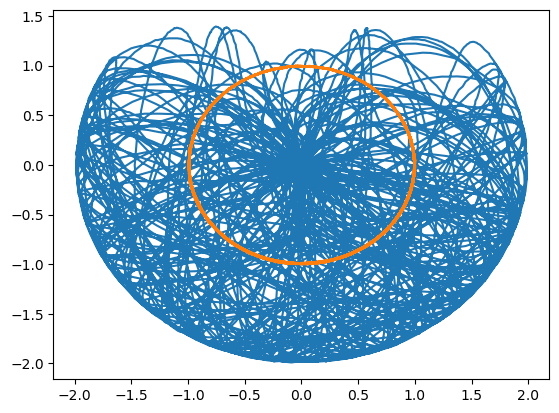

In [5]:
for df_ in df_trimmed:
    plt.plot(df_["x_2"], df_["y_2"])
    plt.plot(df_["x_1"], df_["y_1"])


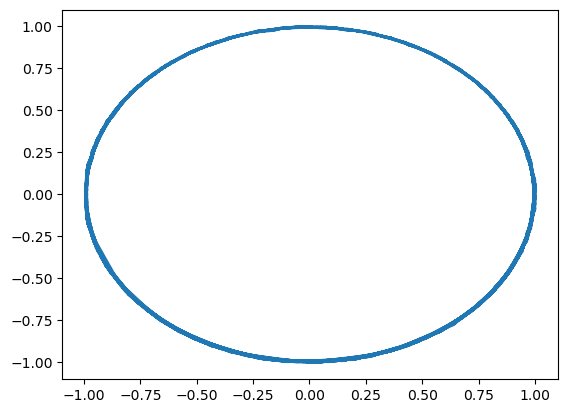

In [6]:
for df_ in df_trimmed:
    plt.plot(df_["x_1"], df_["y_1"])

In [7]:
(df_appended["x_1"]**2+df_appended["y_1"]**2).mean()

0.9902473796096585

In [8]:
(df_appended["x_1"]**2+df_appended["y_1"]**2).std()

0.005745321797176402

<Axes: >

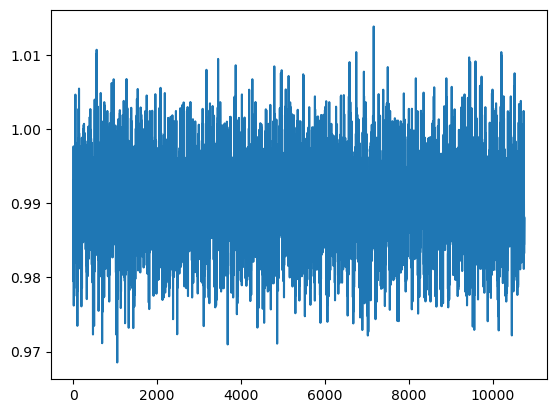

In [9]:
#Visualizing the algebraic constrain in the system
(df_appended["x_1"]**2+df_appended["y_1"]**2).plot()

<Axes: >

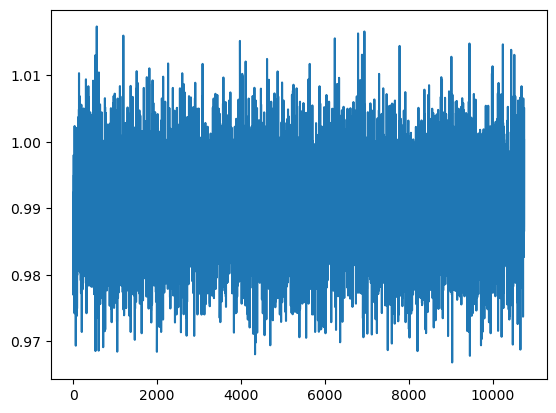

In [10]:
((df_appended["x_1"]-df_appended["x_2"])**2+(df_appended["y_1"]-df_appended["y_2"])**2).plot()

### Smoothening data using Savitzky-Golay Filer

In [11]:
# Finding the first and second order derivative of the states using Savitzky-Golay Filer

data_matrix_smooth_df_list = [
    smooth_data(data_matrix,
                domain_var="t",
                smooth_method ="SG",
                noise_perc=0.1,
                derr_order=2,
                polyorder=2,
                window_smooth=None) #trimming zero derivatives near end points
    for data_matrix in df_trimmed]



if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0].reset_index(drop=True)
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_new= data_matrix_df_smooth_appended[["x_1", "y_1"]]


# data_matrix_df_new = data_matrix_df_new.rename(columns= dict(zip(data_matrix_df_new, ['theta', 'theta_dot'])))

In [12]:
data_matrix_df_smooth_appended

,t,X1,d(X1) /dt,d^2(X1) /dt^2,Y1,d(Y1) /dt,d^2(Y1) /dt^2,X2,d(X2) /dt,d^2(X2) /dt^2,...,d^2(x_1) /dt^2,y_1,d(y_1) /dt,d^2(y_1) /dt^2,x_2,d(x_2) /dt,d^2(x_2) /dt^2,y_2,d(y_2) /dt,d^2(y_2) /dt^2
0,0.05002324,888.89867474,45.50899689,-7.89592262,523.38820920,118.66133378,-18.72737079,844.11507642,42.15262308,-5.81574011,...,-0.02004041,0.57515683,-0.30117090,0.04753140,-0.30300742,0.10698635,-0.01476076,-0.51756689,0.00678852,0.00059868
1,0.06669765,889.65641290,45.37733701,-7.89592262,525.36421391,118.34906585,-18.72737079,844.81713820,42.05564902,-5.81574011,...,-0.02004041,0.57014159,-0.30037834,0.04753140,-0.30122554,0.10674023,-0.01476076,-0.51745361,0.00679850,0.00059868
2,0.08337207,890.41195571,45.24567713,-7.89592262,527.33501174,118.03679793,-18.72737079,845.51758299,41.95867497,-5.81574011,...,-0.02004041,0.56513956,-0.29958578,0.04753140,-0.29944776,0.10649410,-0.01476076,-0.51734017,0.00680848,0.00059868
3,0.10004648,891.16530316,45.11401725,-7.89592262,529.30060268,117.72453000,-18.72737079,846.21641079,41.86170091,-5.81574011,...,-0.02004041,0.56015075,-0.29879322,0.04753140,-0.29767408,0.10624797,-0.01476076,-0.51722656,0.00681847,0.00059868
4,0.11672089,891.91645527,44.98235737,-7.89592262,531.26098673,117.41226207,-18.72737079,846.91362161,41.76472686,-5.81574011,...,-0.02004041,0.55517516,-0.29800067,0.04753140,-0.29590451,0.10600184,-0.01476076,-0.51711278,0.00682845,0.00059868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10742,179.16657370,1138.95395947,52.93263628,7.15485675,816.48674127,-19.52512221,-2.49841068,1188.28323190,103.08215110,17.17804213,...,0.01815953,-0.16874807,0.04955615,0.00634114,0.57051582,0.26162983,0.04359909,-0.42992433,-0.11061565,-0.01156838
10743,179.18324812,1139.83757480,53.05193932,7.15485675,816.16082398,-19.56678174,-2.49841068,1190.00445438,103.36858488,17.17804213,...,0.01815953,-0.16792087,0.04966188,0.00634114,0.57488440,0.26235681,0.04359909,-0.43177039,-0.11080854,-0.01156838
10744,179.19992253,1140.72317943,53.17124236,7.15485675,815.83421205,-19.60844127,-2.49841068,1191.73045297,103.65501866,17.17804213,...,0.01815953,-0.16709191,0.04976762,0.00634114,0.57926511,0.26308380,0.04359909,-0.43361967,-0.11100144,-0.01156838
10745,179.21659694,1141.61077337,53.29054540,7.15485675,815.50690546,-19.65010080,-2.49841068,1193.46122768,103.94145244,17.17804213,...,0.01815953,-0.16626118,0.04987335,0.00634114,0.58365794,0.26381079,0.04359909,-0.43547216,-0.11119433,-0.01156838


## Fomring the candidate library

In [80]:
data_matrix_df_new = df_appended[["x_1", "y_1", "x_2", "y_2"]]
data_matrix_df_new = data_matrix_df_new.sample(frac=1).reset_index(drop=True)
# data_matrix_df_new["Y"] = -data_matrix_df_new["Y"]


poly_degree = 5
from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

#Optionally removing features from the library
terms_to_drop_corr = set()
candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))


Degree of library: 5
# terms in the library: 125
Full candidate library has the following features: Index(['x_1', 'y_1', 'x_2', 'y_2', 'x_1^2', 'x_1 y_1', 'x_1 x_2', 'x_1 y_2',
       'y_1^2', 'y_1 x_2',
       ...
       'y_1 x_2^3 y_2', 'y_1 x_2^2 y_2^2', 'y_1 x_2 y_2^3', 'y_1 y_2^4',
       'x_2^5', 'x_2^4 y_2', 'x_2^3 y_2^2', 'x_2^2 y_2^3', 'x_2 y_2^4',
       'y_2^5'],
      dtype='object', length=125)


## Finding algebraic relationships

In [81]:
from daeFinder import sequentialThLin
from daeFinder import AlgModelFinder
from daeFinder import remove_paranth_from_feat
# Adding the state variables as scipy symbols
# feat_list = list(data_matrix_df_smooth_appended.columns)
feat_list = ["x_1","y_1", "x_2", "y_2"]
feat_list_str = ", ".join(remove_paranth_from_feat(feat_list))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")


down_size = 1000
candidate_lib_downsized = candidate_lib_full.iloc[::down_size, :].reset_index(drop=True)


# seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)

# seq_th_model = sequentialThLin(model_id="LR", coef_threshold= 0.2)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(candidate_lib_downsized, scale_columns= True)

algebraic_model_th.best_models()

Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations


/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients f

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations


/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients f

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients f

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations


/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients f

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations


/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients f

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients f

,y_1 x_2^3,y_1 x_2^4,x_2 y_2^4,x_2,x_1 y_1 y_2^2,x_2 y_2,x_1 x_2 y_2^3,y_1 x_2^2 y_2^2,x_1 y_2,y_2^4,...,y_1^3 x_2,x_1^2 y_1^2,y_1^3 y_2,x_1^3 y_1,x_1 x_2^3,x_1^3 x_2,y_2^2,x_1 y_1^3,x_2^2,x_1^2 y_1^2 y_2
x_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
x_2,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
x_1^2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x_2^2 y_2^3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
x_2 y_2^4,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y_2^5,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y_1 x_2^3,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


## Finding minimum number of data points required

In [ ]:
poly_degree = 4
from daeFinder import sequentialThLin
from daeFinder import AlgModelFinder
from daeFinder import remove_paranth_from_feat
# Adding the state variables as scipy symbols

In [83]:
best_relationship_dict = {}
from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))
feat_list = ["x","y", "theta", "theta_dot"]
feat_list_str = ", ".join(remove_paranth_from_feat(feat_list))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")


for num_points in range(40,100,10):
    # data_matrix_df_new = pd.concat([df_[:num_points][["x","y"]] for df_ in df_trimmed])
    # data_matrix_df_new["Y"] = -data_matrix_df_new["Y"]



    # candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)



    # feat_list = list(data_matrix_df_smooth_appended.columns)


    seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)


    algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

    algebraic_model_th.fit(candidate_lib_full[:num_points], scale_columns= True)
    best_lhs = algebraic_model_th.best_models(1).columns[0]
    best_rhs = list((algebraic_model_th.best_models(1)[best_lhs][abs(algebraic_model_th.best_models(1)[best_lhs])>0.001]).index)
    best_relationship_dict[num_points] = (best_lhs, best_rhs)

Degree of library: 5
# terms in the library: 125
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential 

/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"


Sequential threshold converged in 9 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential th

/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"


Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential th

/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"


Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential th

/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"


Sequential threshold converged in 3 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential th

/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"


Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential th

/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"


Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential th

/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"


Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential th

/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"


Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential th

/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"


Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential th

/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1055: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"


Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential th

In [87]:
num_points = 70
best_relationship_dict[num_points]

('y_1 x_2 y_2', ['x_1^2 y_1 x_2 y_2', 'y_1^3 x_2 y_2', 'r2- metric'])

In [34]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression(fit_intercept=True)

best_lhs = best_relationship_dict[num_points][0]
best_rhs = best_relationship_dict[num_points][1][:-1]
lin_model.fit(X=candidate_lib_full[best_rhs], y=candidate_lib_full[best_lhs])
lin_model.score(X=candidate_lib_full[best_rhs], y=candidate_lib_full[best_lhs])

0.9999394853297325

In [35]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'x_1 x_2': 1.9995929474445422,
 'y_1 y_2': 1.9982998748083953,
 'y_2^2': -0.9995356598301282}

In [18]:
# dict(zip(lin_model.feature_names_in_, lin_model.coef_))

In [19]:
# from sklearn.linear_model import LinearRegression

# lin_model = LinearRegression(fit_intercept=True)
# lin_model.fit(X=candidate_lib_downsized[["y", "y^2"]], y=candidate_lib_downsized["x^2"])
# lin_model.score(X=candidate_lib_downsized[["y", "y^2"]], y=candidate_lib_downsized["x^2"])

In [20]:
# dict(zip(lin_model.feature_names_in_, lin_model.coef_))

## Refine library

In [ ]:
features_to_remove = {x_1**2}

# features_to_remove = {y**2, y*y_dot}


features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

In [164]:
down_size = 2000
candidate_lib_downsized = refined_candid_lib.iloc[::down_size, :].reset_index(drop=True)


seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.02)
# seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.5, coef_threshold= 0.05)

# seq_th_model = sequentialThLin(model_id="LR", coef_threshold= 0.2)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(candidate_lib_downsized, scale_columns= True)

algebraic_model_th.best_models()

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential th

,x_1 y_1,y_1 x_2,y_1^2 x_2,y_1^3 x_2,x_1 y_1^3,y_1 x_2^3,x_1 y_1 x_2^2,x_2,x_2^3,x_1 x_2^2,...,x_1 y_2,x_1 x_2^2 y_2,x_2^3 y_2,x_2 y_2,x_1 y_1^2,x_1 x_2 y_2,x_2^2 y_2,x_1,y_1,y_2
x_1,-0.03109738,-0.03574888,0.01781602,-0.01963817,-0.01462703,-0.11713037,-0.04949706,0.04741894,0.25057258,0.12918578,...,-0.06111201,0.00000000,0.00000000,0.04743021,0.09479974,-0.10313522,-0.17538270,NaN,0.19915991,0.11875423
y_1,0.02780585,0.06023394,-0.06628993,0.04214841,0.00000000,0.00000000,0.00000000,-0.11421229,0.00000000,0.00000000,...,-0.04847388,0.17628871,0.42254743,0.19484828,0.14515062,-0.11407654,-0.15573221,0.63937071,NaN,0.31006152
x_2,-0.02111885,-0.05096230,0.03188066,-0.02001110,-0.00773062,-0.14274865,-0.06620190,NaN,0.29050072,0.13978908,...,-0.01813286,-0.08400541,-0.16782334,-0.05826926,0.00577717,-0.01861363,-0.03778935,0.01946630,-0.01849323,-0.03815725
y_2,0.03072642,0.07787245,0.00000000,0.00000000,-0.01254736,0.32134852,0.16167475,-0.27708600,-0.86687053,-0.42258304,...,-0.19682504,-0.18013345,-0.43873109,-0.19224339,0.11917937,0.40075477,0.89901549,0.37626657,0.31076849,NaN
x_1 x_2,-0.02304013,0.04170843,-0.03539679,0.02631980,0.00000000,0.09089246,0.03147883,0.00000000,0.00000000,0.00000000,...,-0.07265655,-0.10977705,-0.19624561,-0.05714144,0.00000000,-0.09419183,-0.16803192,0.03064273,-0.01901249,0.00000000
x_1 y_2,0.04884474,0.03484970,0.00000000,0.00000000,0.01515883,0.08605292,0.04764558,-0.10222615,-0.37716720,-0.20913188,...,NaN,0.41603953,0.84126373,0.29817229,-0.03255901,-0.05437026,-0.16684437,-0.16012123,-0.03915338,-0.16482567
y_1^2,-0.07146820,-0.16785584,0.21490224,-0.21109945,-0.08431315,0.00000000,0.00000000,0.00000000,-0.80455907,-0.53142283,...,0.12188200,0.57280607,0.96878136,0.23277981,0.08510580,0.20330133,0.29201362,-0.11055437,-0.25018153,0.06301151
y_1 x_2,0.03526458,NaN,-0.06890967,0.05055353,0.01924504,0.23976562,0.10576894,-0.14814143,-0.36158099,-0.16012723,...,0.01673792,0.07247433,0.16129953,0.06515311,-0.02363133,0.00000000,0.00000000,-0.04464713,0.02723551,0.02906411
x_2^2,-0.01321022,0.01972483,-0.01462966,0.00984487,0.00000000,0.04863703,0.01770393,0.00000000,0.00000000,0.00000000,...,-0.03656996,-0.05201154,-0.09679055,-0.03087181,-0.00526081,-0.04013905,-0.07213613,0.00000000,-0.02151786,0.00000000
x_2 y_2,0.01800369,0.03625791,-0.02295237,0.01246602,0.00000000,0.08763313,0.04515666,-0.09270382,-0.24994996,-0.12944980,...,0.08019659,0.27806838,0.57315952,NaN,0.01257618,-0.08553175,-0.19142415,0.03865361,0.04528446,-0.04367162


## Finding minimum number of data points required

In [ ]:
best_relationship_dict = {}
features_to_remove = {x_1**2}

# features_to_remove = {y**2, y*y_dot}


features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)


for num_points in range(35,40,1):
    # data_matrix_df_new = pd.concat([df_[:num_points][["x","y"]] for df_ in df_trimmed])
    # data_matrix_df_new["Y"] = -data_matrix_df_new["Y"]



    # candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)



    # feat_list = list(data_matrix_df_smooth_appended.columns)


    seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)


    algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

    algebraic_model_th.fit(refined_candid_lib[:num_points], scale_columns= True)
    best_lhs = algebraic_model_th.best_models(1).columns[0]
    best_rhs = list((algebraic_model_th.best_models(1)[best_lhs][abs(algebraic_model_th.best_models(1)[best_lhs])>0.001]).index)
    best_relationship_dict[num_points] = (best_lhs, best_rhs)

Sequential threshold converged in 3 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 6 iterations
Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential th

In [166]:
num_points = 39
best_relationship_dict[num_points]

('x_1 x_2^3', ['x_2^2', 'y_1^2 x_2^2', 'x_2^4', 'r2- metric'])

In [ ]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression(fit_intercept=True)

best_lhs = best_relationship_dict[num_points][0]
best_rhs = best_relationship_dict[num_points][1][:-1]
lin_model.fit(X=refined_candid_lib[best_rhs], y=refined_candid_lib[best_lhs])
lin_model.score(X=refined_candid_lib[best_rhs], y=refined_candid_lib[best_lhs])

0.9999394853297325

In [ ]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'x_1 x_2': 1.9995929474445422,
 'y_1 y_2': 1.9982998748083953,
 'y_2^2': -0.9995356598301282}

## SVD analysis to track condition number

In [186]:
poly_degree = 5
from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)


features_to_remove = {x_1**2}
# features_to_remove = {y**2, y*y_dot}
features_to_remove, refined_candid_lib_1 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)


features_to_remove = {x_1**2, y_1*y_2}
# features_to_remove = {y**2, y*y_dot}
features_to_remove, refined_candid_lib_2 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {x_1**2, y_1*y_2, y_2**2}
# features_to_remove = {y**2, y*y_dot}
features_to_remove, refined_candid_lib_3 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {x_1**2, y_1*y_2, y_2**2, y_1*y_2}
# features_to_remove = {y**2, y*y_dot}
features_to_remove, refined_candid_lib_4 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

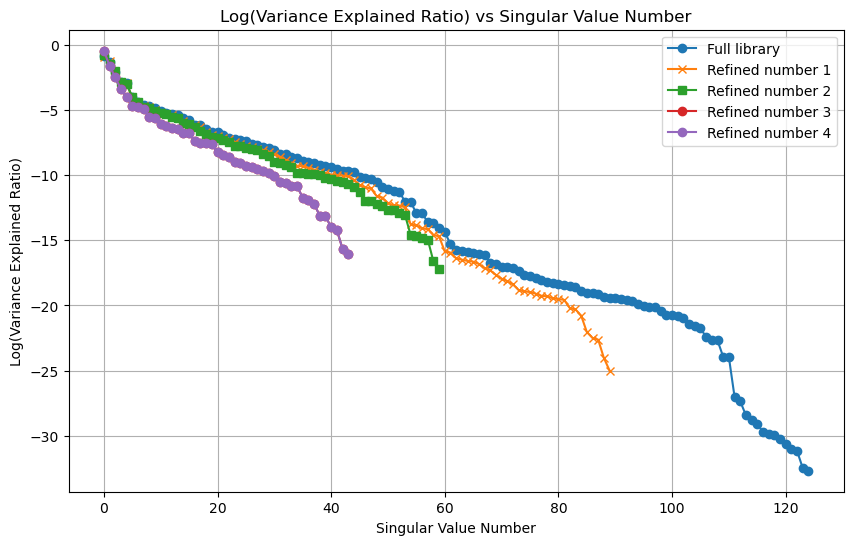

In [187]:
# Perform Singular Value Decomposition (SVD) on the candidate libraries
U_full, s_full, Vt_full = np.linalg.svd(candidate_lib_full, full_matrices=False)
U_refined_1, s_refined_1, Vt_refined_1 = np.linalg.svd(refined_candid_lib_1, full_matrices=False)
U_refined_2, s_refined_2, Vt_refined_2 = np.linalg.svd(refined_candid_lib_2, full_matrices=False)
U_refined_3, s_refined_3, Vt_refined_3 = np.linalg.svd(refined_candid_lib_3, full_matrices=False)
U_refined_4, s_refined_4, Vt_refined_4 = np.linalg.svd(refined_candid_lib_4, full_matrices=False)



# Calculate the explained variance ratio for the candidate libraries
explained_variance_ratio_full = (s_full ** 2) / np.sum(s_full ** 2)
explained_variance_ratio_refined_1 = (s_refined_1 ** 2) / np.sum(s_refined_1 ** 2)
explained_variance_ratio_refined_2 = (s_refined_2 ** 2) / np.sum(s_refined_2 ** 2)
explained_variance_ratio_refined_3 = (s_refined_3 ** 2) / np.sum(s_refined_3 ** 2)
explained_variance_ratio_refined_4 = (s_refined_4 ** 2) / np.sum(s_refined_4 ** 2)



# Plot the log of the explained variance ratio for all libraries
plt.figure(figsize=(10, 6))
plt.plot(np.log(explained_variance_ratio_full), marker='o', label='Full library')
plt.plot(np.log(explained_variance_ratio_refined_1), marker='x', label='Refined number 1')
plt.plot(np.log(explained_variance_ratio_refined_2), marker='s', label='Refined number 2')
plt.plot(np.log(explained_variance_ratio_refined_3), marker='o', label='Refined number 3')
plt.plot(np.log(explained_variance_ratio_refined_4), marker='o', label='Refined number 4')


plt.xlabel('Singular Value Number')
plt.ylabel('Log(Variance Explained Ratio)')
plt.title('Log(Variance Explained Ratio) vs Singular Value Number')
plt.legend()
plt.grid(True)

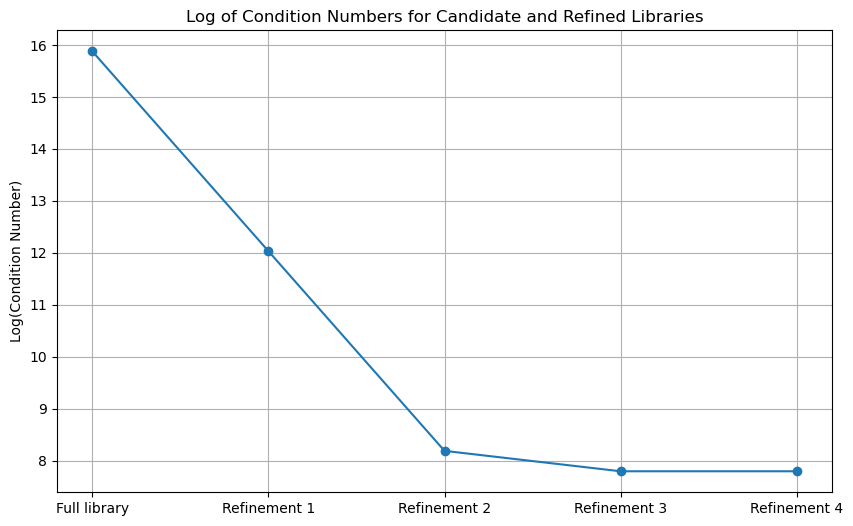

In [188]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the condition numbers
cond_numbers = [np.linalg.cond(lib) for lib in [candidate_lib_full, refined_candid_lib_1, refined_candid_lib_2,
                                                 refined_candid_lib_3, refined_candid_lib_4]]
# cond_num_full = np.linalg.cond(candidate_lib_full)
# cond_num_refined_1 = np.linalg.cond(refined_candid_lib_1)
# cond_num_refined_2 = np.linalg.cond(refined_candid_lib_2)
# cond_num_refined_3 = np.linalg.cond(refined_candid_lib_3)


# Plot the log of condition numbers
plt.figure(figsize=(10, 6))
plt.plot(["Full library","Refinement 1","Refinement 2", "Refinement 3", "Refinement 4"], np.log(cond_numbers), marker='o')
plt.ylabel('Log(Condition Number)')
plt.title('Log of Condition Numbers for Candidate and Refined Libraries')
plt.grid(True)
plt.show()
